In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
% matplotlib inline

In [2]:
sms = pd.read_csv("../spam.csv", encoding = 'latin-1');
sms = sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
sms = sms.rename(columns = {"v1": "Label", "v2": "Text"})
sms["Length"] = sms["Text"].apply(len)

## Histogram of message length by type

Label
ham     Axes(0.125,0.125;0.775x0.755)
spam    Axes(0.125,0.125;0.775x0.755)
Name: Length, dtype: object

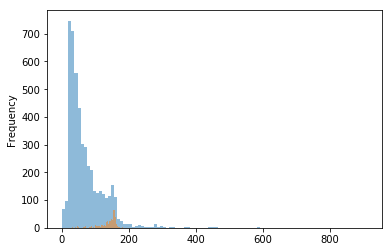

In [3]:
sms.groupby("Label").Length.plot(kind = "hist", alpha = 0.5, bins = 100)

In [4]:
to_process = sms["Text"].copy()
to_process = to_process.str.lower()
stop_words = set(stopwords.words("english"))

def clean_message(text):
    # te
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = [word for word in text.split() if word not in stopwords.words("english")]
    
    return " ".join(text)

text_cleaned = to_process.apply(clean_message)

In [5]:
from collections import Counter
freqSpam = Counter(" ".join(text_cleaned[sms["Label"] == "spam"]).split()).most_common(20)
freqHam = Counter(" ".join(text_cleaned[sms["Label"] == "ham"]).split()).most_common(20)

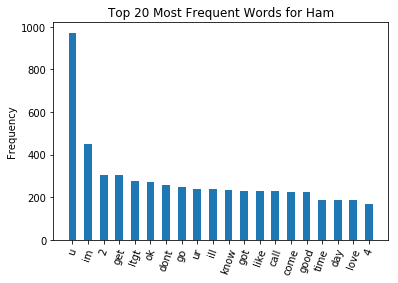

In [6]:
import matplotlib.pyplot as plt
labels, ys = zip(*freqHam)
xs = np.arange(len(labels)) 
width = 0.5
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels)
plt.xticks(rotation=70)
plt.title("Top 20 Most Frequent Words for Ham")
plt.ylabel("Frequency")
plt.show()

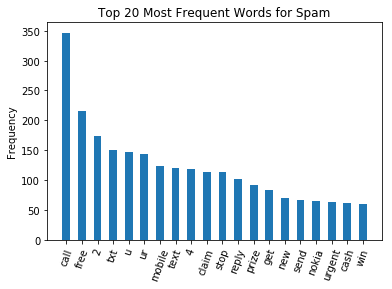

In [7]:
labels, ys = zip(*freqSpam)
xs = np.arange(len(labels)) 
width = 0.5
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels)
plt.xticks(rotation=70)
plt.title("Top 20 Most Frequent Words for Spam")
plt.ylabel("Frequency")
plt.show()

In [8]:
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_cleaned)
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import matplotlib

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


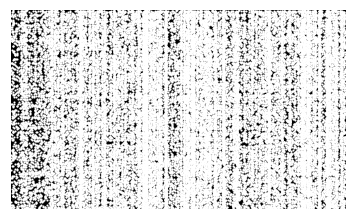

In [9]:
ax = plot_coo_matrix(features)
ax.figure.show()

## Split Data

In [10]:
featureTrain, featureTest, labelTrain, labelTest = train_test_split(features, sms["Label"],
                                                                test_size = 0.2, random_state = 1234)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

### Choose different kernels and bandwidth for SVC 

In [12]:
kernels = {'rbf' : 'rbf','polynominal' : 'poly', 'sigmoid': 'sigmoid'}
predScore = []
for k, v in kernels.items():
    for i in np.linspace(0.05, 1, num = 20):
        svc = SVC(kernel = v, gamma = i)
        svc.fit(featureTrain, labelTrain)
        pred = svc.predict(featureTest)
        predScore.append((k, [i, accuracy_score(labelTest, pred)]))

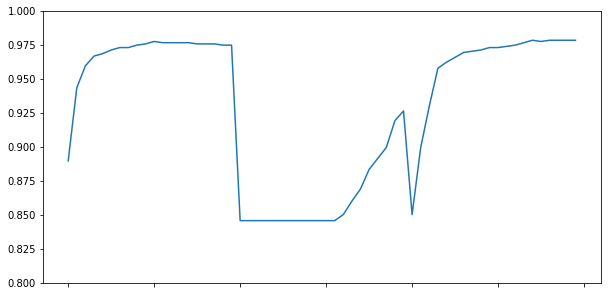

In [13]:
df = pd.DataFrame.from_items(predScore,orient='index', columns=['Gamma','Score'])
df['Score'].plot(kind='line', figsize=(10,5), ylim=(0.8,1.0),y = "Score")

the `sigmoid` kernel with `gamma = 1` produces an accuracy of 97.8475%.

### Elastic net
expected to perform better than using only $\ell_1$ or $\ell_2$ regularization

In [14]:
labelTrain2 = labelTrain == "ham"
labelTest2 = labelTest == "spam"
predScore = []
for j in np.linspace(0.01, 1, num = 20):
    eln = SGDClassifier(loss = 'log', penalty = 'elasticnet', alpha = 0.0001, l1_ratio = j)
    eln.fit(featureTrain, labelTrain)
    pred = eln.predict(featureTest)
    predScore.append((i, [j, accuracy_score(labelTest, pred)]))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [15]:
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ['l1_ratio', 'Score'])

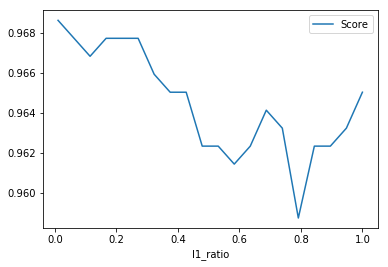

In [16]:
df.plot(x = 'l1_ratio', y = 'Score', kind = "line")

When `l1_ratio = 0.05`, the prediction has an accuracy of 96.9507%.

## Decision Tree

In [17]:
predScore = []
for i in np.arange(5,31):
    dtc = DecisionTreeClassifier(min_samples_split = i, random_state = 2345)
    dtc.fit(featureTrain, labelTrain)
    pred = dtc.predict(featureTest)
    predScore.append((i,[i, accuracy_score(labelTest, pred)]))

In [18]:
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["min_samples_split", "Score"])

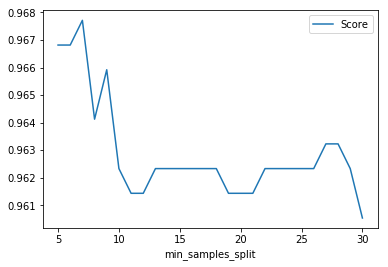

In [19]:
df.plot(x = 'min_samples_split', y = 'Score', kind = "line")

## Multinomial Naive Bayes

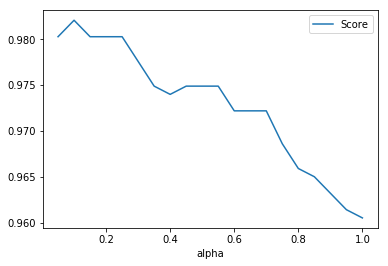

In [20]:
predScore = []
for i in np.linspace(0.05, 1, num = 20):
    mnb = MultinomialNB(alpha = i)
    mnb.fit(featureTrain, labelTrain)
    pred = mnb.predict(featureTest)
    predScore.append((i,[i, accuracy_score(labelTest, pred)]))
  
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["alpha", "Score"])
df.plot(x = 'alpha', y = 'Score', kind = "line")

## K-Nearest Neighbor

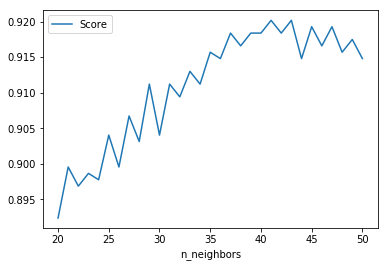

In [21]:
predScore = []
for i in np.arange(20, 51):
    knc = KNeighborsClassifier(n_neighbors = i)
    knc.fit(featureTrain, labelTrain)
    pred = knc.predict(featureTest)
    predScore.append((i,[i, accuracy_score(labelTest, pred)]))
  
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["n_neighbors", "Score"])
df.plot(x = 'n_neighbors', y = 'Score', kind = "line")

## Random Forest

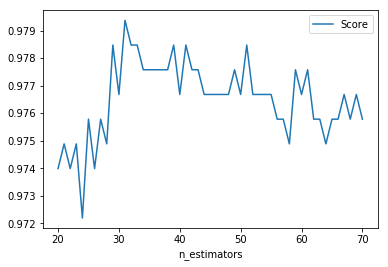

In [23]:
predScore = []
for i in np.arange(20, 71):
    rfc = RandomForestClassifier(n_estimators = i, random_state = 2345)
    rfc.fit(featureTrain, labelTrain)
    pred = rfc.predict(featureTest)
    predScore.append((i,[i, accuracy_score(labelTest, pred)]))
  
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["n_estimators", "Score"])
df.plot(x = 'n_estimators', y = 'Score', kind = "line")

## Adaboost

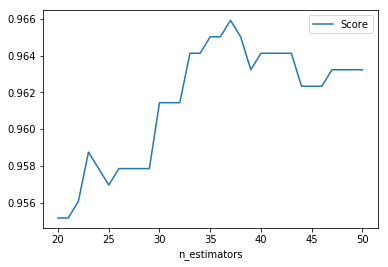

In [24]:
predScore = []
for i in np.arange(20, 51):
    abc = AdaBoostClassifier(n_estimators = i, random_state = 2345)
    abc.fit(featureTrain, labelTrain)
    pred = abc.predict(featureTest)
    predScore.append((i, [i, accuracy_score(labelTest, pred)]))
    
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["n_estimators", "Score"])
df.plot(x = 'n_estimators', y = 'Score', kind = "line")

## Bagging

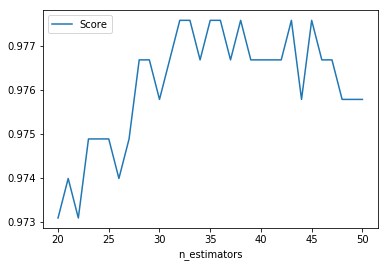

In [25]:
predScore = []
for i in np.arange(20, 51):
    bgc = BaggingClassifier(n_estimators = i, random_state = 2345)
    bgc.fit(featureTrain, labelTrain)
    pred = bgc.predict(featureTest)
    predScore.append((i, [i, accuracy_score(labelTest, pred)]))
    
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["n_estimators", "Score"])
df.plot(x = 'n_estimators', y = 'Score', kind = "line")

## ExtraTrees

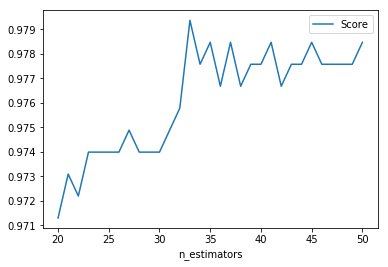

In [26]:
predScore = []
for i in np.arange(20, 51):
    etc = ExtraTreesClassifier(n_estimators = i, random_state = 2345)
    etc.fit(featureTrain, labelTrain)
    pred = etc.predict(featureTest)
    predScore.append((i, [i, accuracy_score(labelTest, pred)]))
    
df = pd.DataFrame.from_items(predScore, orient = "index", columns = ["n_estimators", "Score"])
df.plot(x = 'n_estimators', y = 'Score', kind = "line")